In [1]:
import os
import random
import yaml
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.interpolate import CubicSpline, interp1d

In [2]:
fmin = 4e3
fmax = 32e3
octavespacing = 1 / 4.0  # 8.0
n_frequencies = int(np.log2(fmax / fmin) / octavespacing) + 1
fvals = (
    np.logspace(
        np.log2(fmin / 1000.0),
        np.log2(fmax / 1000.0),
        num=n_frequencies,
        endpoint=True,
        base=2,
    )
    * 1000.0
)

fvals, len(fvals)

(array([ 4000.        ,  4756.82846001,  5656.85424949,  6727.17132203,
         8000.        ,  9513.65692002, 11313.70849898, 13454.34264406,
        16000.        , 19027.31384004, 22627.41699797, 26908.68528812,
        32000.        ]),
 13)

In [10]:
nfs = len(fvals)
nfs


13

In [ ]:
0, 3, 6, 9, 12

In [13]:
np.linspace(0,24,5)

array([ 0.,  6., 12., 18., 24.])

In [ ]:
[fvals[i] for i in [0, 6, 12, 18, 24]]


In [3]:
n_levels = 6
levels = np.linspace(20, 100, n_levels)
levels

array([ 20.,  36.,  52.,  68.,  84., 100.])

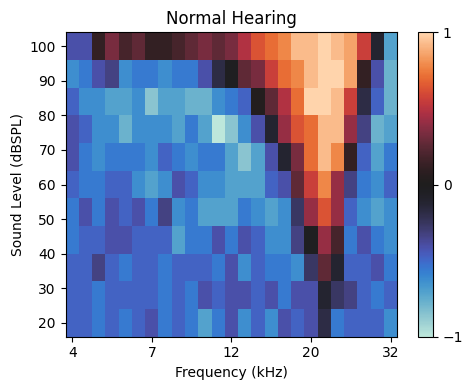

In [2]:
data_norm = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-d2v-stimpar_ts/DATA-25fs_11dbs_22000cf-response_map.pkl', 'rb'))
# data_norm = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell/DATA-25fs_11dbs_24000cf-response_map.pkl', 'rb'))

freqs_log = data_norm['freqs_log']
levels = data_norm['levels']

cmap = sns.color_palette("icefire", as_cmap=True)
# cmap = cm.twilight

fig, axs = plt.subplots(1,1,figsize=(5,4))  #, layout='constrained')

matrix = data_norm['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs.pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap, vmin=-1, vmax=1) 
axs.set_title('Normal')
axs.set_ylabel('Sound Level (dBSPL)')
axs.set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs.set_xticklabels([4, 7, 12, 20, 32])

# title = 'Hearing Loss' if 'loss' in self.hearing else 'Normal Hearing'
axs.set_title('Normal Hearing')
axs.set_xlabel('Frequency (kHz)')

fig.colorbar(im, ticks=[-1,0,1])
# fig.set_dpi(200)
fig.tight_layout()
# fig.savefig('22kHz-normal_hearing_normalized.pdf', dpi=300)

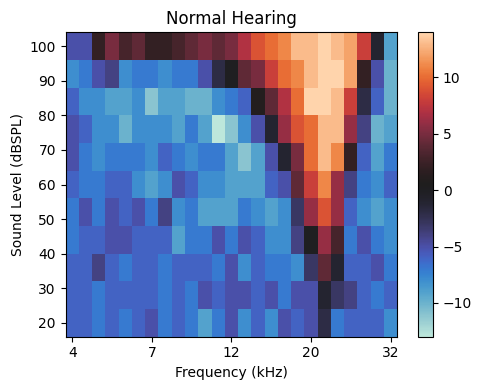

In [6]:
data_norm = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-d2v-stimpar_ts/DATA-25fs_11dbs_22000cf-response_map.pkl', 'rb'))
# data_norm = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell/DATA-25fs_11dbs_24000cf-response_map.pkl', 'rb'))

freqs_log = data_norm['freqs_log']
levels = data_norm['levels']

cmap = sns.color_palette("icefire", as_cmap=True)
# cmap = cm.twilight

fig, axs = plt.subplots(1,1,figsize=(5,4))  #, layout='constrained')

matrix = data_norm['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs.pcolormesh(freqs_log, levels, matrix-5, cmap=cmap)  #, vmin=-1, vmax=1) 
axs.set_title('Normal')
axs.set_ylabel('Sound Level (dBSPL)')
axs.set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs.set_xticklabels([4, 7, 12, 20, 32])

# title = 'Hearing Loss' if 'loss' in self.hearing else 'Normal Hearing'
axs.set_title('Normal Hearing')
axs.set_xlabel('Frequency (kHz)')

fig.colorbar(im)  #, ticks=[-1,0,1])
# fig.set_dpi(200)
fig.tight_layout()
# fig.savefig('22kHz-normal_hearing_normalized.pdf', dpi=300)

## Functions

In [23]:
def get_response_map(levels, freqs, results, response, pyr_id):

    nreps = 1

    matrix = np.zeros((len(levels), len(freqs)))

    for stim, iteration in list(results.values()):

        for i in range(nreps):

            vec = iteration[i]
            spikes = vec[('pyramidal', pyr_id)][1]
            n_spikes = ((spikes >= response[0]) & (spikes < response[1])).sum()

            freq = stim.key()['f0']
            level = stim.key()['dbspl']

            j = freqs.index(freq)
            i = levels.index(level)

            matrix[i,j] += n_spikes
    
    return matrix

In [10]:
def get_cell_nspikes(cell_type, results, response, pyr_ids=None):
    n_spikes = []
    cell_ids = []

    for stim, iterations in results.values():
        rep_n_spikes = []
        rep_cell_ids = []
        for cell, vec in iterations.items():
            if isinstance(cell, str):
                continue
            save_rate = True if ('sgc' in cell_type) or (('pyr' in cell_type) and (cell[1] in pyr_ids)) else False
            if (cell_type in cell[0]) and save_rate:
                spikes = np.array(vec[1])
                num_spikes = ((spikes >= response[0]) & (spikes < response[1])).sum()
                rep_n_spikes.append(num_spikes)
                rep_cell_ids.append(cell[1])

        n_spikes.append(rep_n_spikes)
        cell_ids.append(rep_cell_ids)

    n_spikes = np.mean(n_spikes, axis=0)

    return cell_ids[0], np.array(n_spikes)

## with IC

In [3]:
data_norm = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell_ic/DATA-25fs_11dbs_16000cf-response_map-ic.pkl', 'rb'))
results_norm = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell_ic/25fs_11dbs_16000cf-results_od.pkl', 'rb'))


--No graphics will be displayed.


In [11]:
temp = 0

pyr_vs = []
for sound, data in results_norm.items():
    cell_data = data[1][0]
    for cell_info, cell_rec in cell_data.items():
        cell_type = cell_info[0]
        if 'pyr' in cell_type:
            cell_v = cell_rec[0]
            pyr_vs.append(cell_v)
    break

In [6]:
fmin = 4e3
fmax = 32e3
octavespacing = 1 / 8.0  # 8.0
n_frequencies = int(np.log2(fmax / fmin) / octavespacing) + 1
fvals = (
    np.logspace(
        np.log2(fmin / 1000.0),
        np.log2(fmax / 1000.0),
        num=n_frequencies,
        endpoint=True,
        base=2,
    )
    * 1000.0
)

n_levels = 11
levels = np.linspace(20, 100, n_levels)

In [5]:
baseline = [50,100]
response = [100,200]

spont_spikes = 0
spont_time = 0

pop_type = 'pyramidal'
cell_ind = 2143

for stim, iterations in list(results_norm.values()):
    for vec in list(iterations.values()):
        # print(f"plotting - f = {round(stim.opts['f0'])}, dbspl = {stim.opts['dbspl']}")
        spikes = vec[(pop_type, cell_ind)][1]
        spont_spikes += ((spikes >= baseline[0]) * (spikes < baseline[1])).sum()
        spont_time += baseline[1] - baseline[0]

spont_rate = spont_spikes / spont_time
spont_rate

np.float64(0.1)

In [9]:
nreps = 1

freqs = list(fvals)
levels = list(levels)

matrix = np.zeros((len(levels), len(freqs)))

for stim, iteration in list(results_norm.values()):

    for i in range(nreps):

        vec = iteration[i]
        spikes = vec[(pop_type, cell_ind)][1]
        n_spikes = ((spikes >= response[0]) & (spikes < response[1])).sum()

        freq = stim.key()['f0']
        level = stim.key()['dbspl']

        j = freqs.index(freq)
        i = levels.index(level)

        # response_map_df.loc[level, [freq]] += n_spikes - spont_rate * (response[1] - response[0])
        matrix[i,j] += n_spikes - spont_rate * (response[1] - response[0])

matrix /= nreps

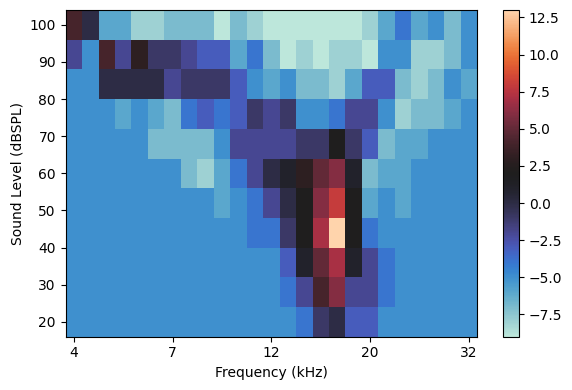

In [13]:
cmap = sns.color_palette("icefire", as_cmap=True)

b = (freqs[-1] - freqs[0]) / np.log(freqs[-1] / freqs[0])
a = freqs[0] - b * np.log(freqs[0])
freqs_log = a + b * np.log(freqs)

fig, axs = plt.subplots(1,1,figsize=(6,4))
im = axs.pcolormesh(freqs_log, levels, matrix, cmap=cmap)
axs.set_xlabel('Frequency (kHz)')
axs.set_ylabel('Sound Level (dBSPL)')
# axs.set_xscale('log')
axs.set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs.set_xticklabels([round(np.ceil(freqs[i]/1000)) for i in [0, 6, 12, 18, 24]])
fig.colorbar(im)  #, ticks=[-1,0,1])
fig.tight_layout()

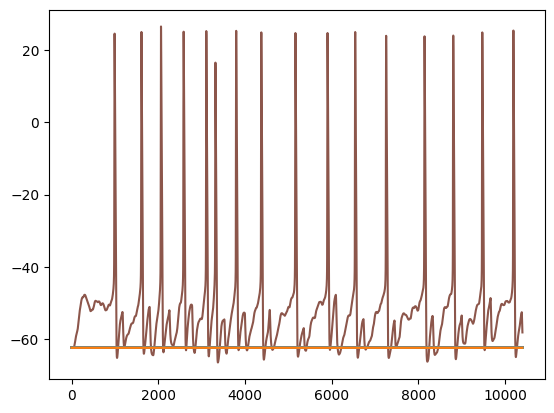

In [13]:
for pyr_v in pyr_vs:
    plt.plot(pyr_v)

## CNModel

In [11]:
data_norm = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-longerstim/DATA-25fs_11dbs_22000cf-response_map.pkl', 'rb'))
results_norm = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-longerstim/25fs_11dbs_22000cf-results_od.pkl', 'rb'))

data_loss_m1_70_erev = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-erev_-45_13000loss-m1_70/DATA-25fs_11dbs_22000cf-response_map-loss.pkl', 'rb'))
results_loss_m1_70_erev = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-erev_-45_13000loss-m1_70/25fs_11dbs_22000cf-results_od.pkl', 'rb'))


In [ ]:
data_loss_m1_70 = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-longerstim_loss-m1_70/DATA-25fs_11dbs_22000cf-response_map-loss.pkl', 'rb'))
results_loss_m1_70 = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-longerstim_loss-m1_70/25fs_11dbs_22000cf-results_od.pkl', 'rb'))

data_loss_m3_60 = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-longerstim_loss-m3_60/DATA-25fs_11dbs_22000cf-response_map-loss.pkl', 'rb'))
results_loss_m3_60 = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-longerstim_loss-m3_60/25fs_11dbs_22000cf-results_od.pkl', 'rb'))

--No graphics will be displayed.


In [14]:
freqs_log = data_norm['freqs_log']
freqs = data_norm['freqs']
levels = data_norm['levels']

### Rate-level functions

In [ ]:
data_norm = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell-longerstim/DATA-25fs_11dbs_16000cf-response_map.pkl', 'rb'))
data_norm_ic = pickle.load(open('/scratch/kedoxey/dcnmodel_scratch/output/response_maps-single_cell_ic/DATA-25fs_11dbs_16000cf-response_map-ic.pkl', 'rb'))

freqs_log = data_norm['freqs_log']
levels = data_norm['levels']

In [8]:
freqs = data_norm['freqs']
matrix_norm = data_norm['matrix']
matrix_loss_m1_70_erev = data_loss_m1_70_erev['matrix']
matrix_loss_m1_70 = data_loss_m1_70['matrix']
matrix_loss_m3_60 = data_loss_m3_60['matrix']

cf_freq = 22000
cf_idx = (np.abs(np.array(freqs)-cf_freq)).argmin()

rate_level_norm = matrix_norm[:,cf_idx]
rate_level_loss_m1_70_erev = matrix_loss_m1_70_erev[:,cf_idx]
rate_level_loss_m1_70 = matrix_loss_m1_70[:,cf_idx]
rate_level_loss_m3_60 = matrix_loss_m3_60[:,cf_idx]

cf_freq = 16000
# cf_idx = (np.abs(np.array(freqs)-cf_freq)).argmin()
# rate_level_ic = matrix_ic[:,cf_idx]

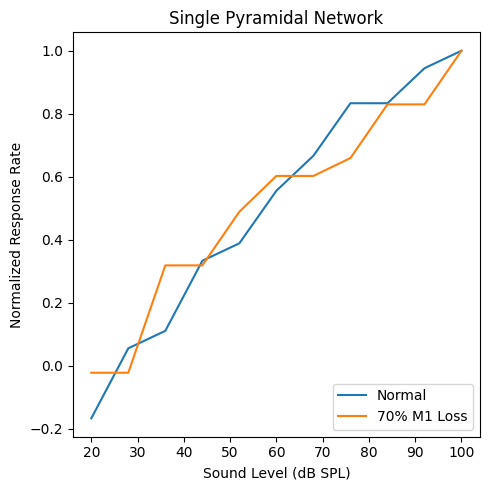

In [7]:
fig, axs = plt.subplots(1,1,figsize=(5,5))

axs.plot(levels,rate_level_norm/np.max(rate_level_norm), label='Normal')
axs.plot(levels,rate_level_loss_m1_70/np.max(rate_level_loss_m1_70), label='70% M1 Loss')
# axs.plot(levels,rate_level_loss_m3_60/np.max(rate_level_loss_m3_60), label='60% M3 Loss')
axs.set_ylabel('Normalized Response Rate')
axs.set_xlabel('Sound Level (dB SPL)')

axs.legend(loc='lower right')
axs.set_title('Single Pyramidal Network')

fig.tight_layout()
# fig.set_dpi(300)

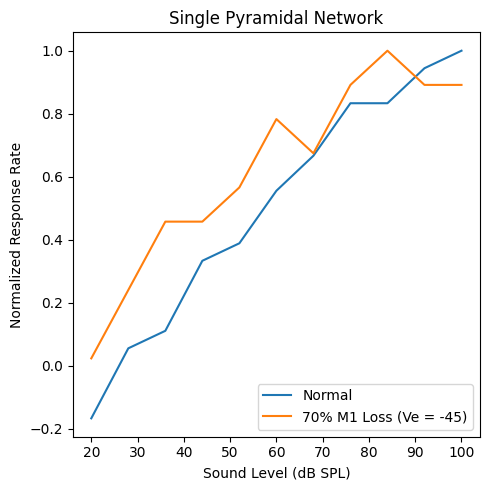

In [9]:
fig, axs = plt.subplots(1,1,figsize=(5,5))

axs.plot(levels,rate_level_norm/np.max(rate_level_norm), label='Normal')
axs.plot(levels,rate_level_loss_m1_70_erev/np.max(rate_level_loss_m1_70_erev), label='70% M1 Loss (Ve = -45)')
# axs.plot(levels,rate_level_loss_m3_60/np.max(rate_level_loss_m3_60), label='60% M3 Loss')
axs.set_ylabel('Normalized Response Rate')
axs.set_xlabel('Sound Level (dB SPL)')

axs.legend(loc='lower right')
axs.set_title('Single Pyramidal Network')

fig.tight_layout()
# fig.set_dpi(300)

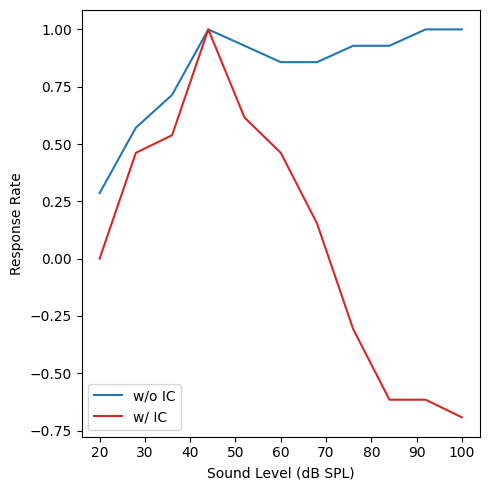

In [4]:

freqs = data_norm['freqs']
matrix_norm = data_norm['matrix']
matrix_ic = data_norm_ic['matrix']

cf_freq = 16000
cf_idx = (np.abs(np.array(freqs)-cf_freq)).argmin()
rate_level_norm = matrix_norm[:,cf_idx]
rate_level_ic = matrix_ic[:,cf_idx]

fig, axs = plt.subplots(1,1,figsize=(5,5))

axs.plot(levels,rate_level_norm/np.max(rate_level_norm), label='w/o IC')

axs.plot(levels,rate_level_ic/np.max(rate_level_ic), label='w/ IC', color='tab:red')
axs.set_ylabel('Response Rate')
axs.set_xlabel('Sound Level (dB SPL)')

axs.legend(loc='lower left')

fig.tight_layout()

### Response Maps

In [15]:
stimpar = {
    "dur": 0.26,
    "pip": 0.1,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 200],
}

In [33]:
pyr_id = list(results_norm[list(results_norm.keys())[0]][1][0].keys())[0][1]

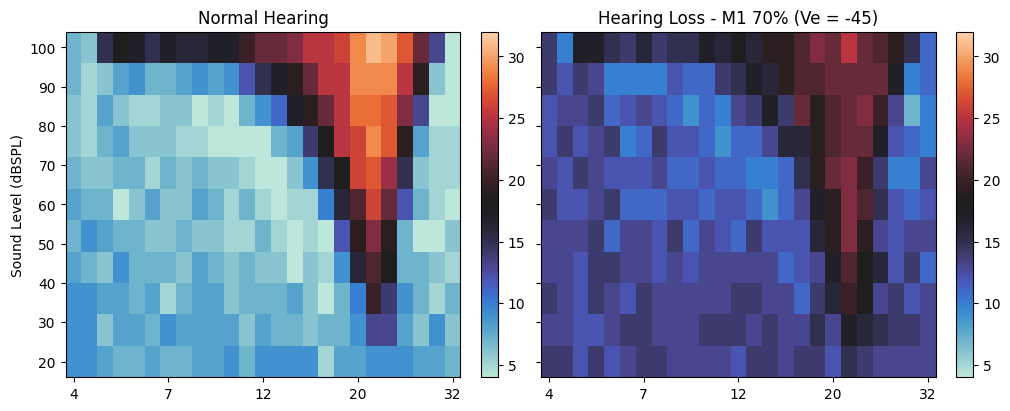

In [38]:

cmap = sns.color_palette("icefire", as_cmap=True)
# matrix_diff = rm_data_loss_m1_95['matrix'] - rm_data_norm['matrix']

fig, axs = plt.subplots(1,2,figsize=(10,4), layout='constrained', sharex=True, sharey=True)

matrix = get_response_map(levels, freqs, results_norm, stimpar['response'], pyr_id)
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[0].pcolormesh(freqs_log, levels, matrix, cmap=cmap, vmin=4, vmax=32)
axs[0].set_title('Normal Hearing')
axs[0].set_ylabel('Sound Level (dBSPL)')
axs[0].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[0].set_xticklabels([4, 7, 12, 20, 32])
fig.colorbar(im)

matrix = get_response_map(levels, freqs, results_loss_m1_70_erev, stimpar['response'], pyr_id)
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[1].pcolormesh(freqs_log, levels, matrix, cmap=cmap, vmin=4, vmax=32) 
axs[1].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[1].set_xticklabels([4, 7, 12, 20, 32])
axs[1].set_title('Hearing Loss - M1 70% (Ve = -45)')


fig.colorbar(im)  #, ticks=[-1,0,1]);
# fig.savefig('normal_vs_loss-erev_45-norm.png', dpi=300)

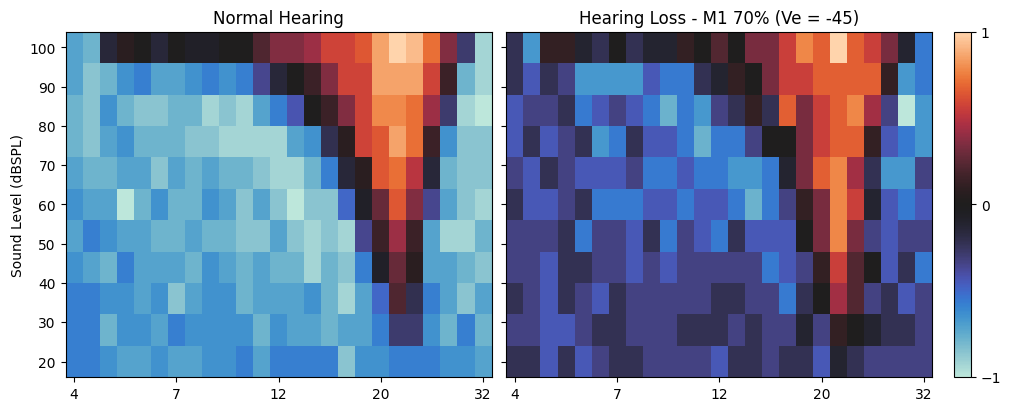

In [39]:

cmap = sns.color_palette("icefire", as_cmap=True)
# matrix_diff = rm_data_loss_m1_95['matrix'] - rm_data_norm['matrix']

fig, axs = plt.subplots(1,2,figsize=(10,4), layout='constrained', sharex=True, sharey=True)

matrix = get_response_map(levels, freqs, results_norm, stimpar['response'], pyr_id)
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[0].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap, vmin=-1, vmax=1)
axs[0].set_title('Normal Hearing')
axs[0].set_ylabel('Sound Level (dBSPL)')
axs[0].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[0].set_xticklabels([4, 7, 12, 20, 32])

matrix = get_response_map(levels, freqs, results_loss_m1_70_erev, stimpar['response'], pyr_id)
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[1].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap, vmin=-1, vmax=1) 
axs[1].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[1].set_xticklabels([4, 7, 12, 20, 32])
axs[1].set_title('Hearing Loss - M1 70% (Ve = -45)')


fig.colorbar(im, ticks=[-1,0,1]);
# fig.savefig('normal_vs_loss-erev_45-norm.png', dpi=300)

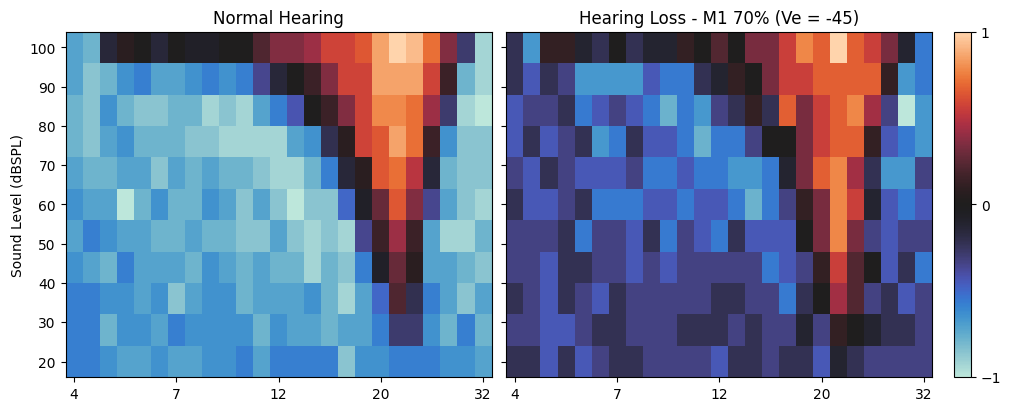

In [14]:
cmap = sns.color_palette("icefire", as_cmap=True)
# matrix_diff = rm_data_loss_m1_95['matrix'] - rm_data_norm['matrix']

fig, axs = plt.subplots(1,2,figsize=(10,4), layout='constrained', sharex=True, sharey=True)

matrix = data_norm['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[0].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap)  #, vmin=-1, vmax=1) 
axs[0].set_title('Normal Hearing')
axs[0].set_ylabel('Sound Level (dBSPL)')
axs[0].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[0].set_xticklabels([4, 7, 12, 20, 32])

matrix = data_loss_m1_70_erev['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[1].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap)  #, vmin=-1, vmax=1) 
axs[1].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[1].set_xticklabels([4, 7, 12, 20, 32])
axs[1].set_title('Hearing Loss - M1 70% (Ve = -45)')


fig.colorbar(im, ticks=[-1,0,1]);
fig.savefig('normal_vs_loss-erev_45-norm.png', dpi=300)

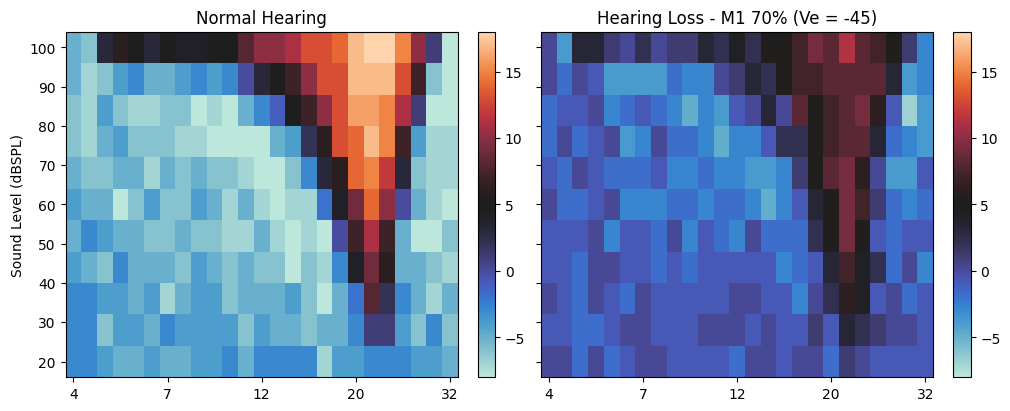

In [13]:
cmap = sns.color_palette("icefire", as_cmap=True)
# matrix_diff = rm_data_loss_m1_95['matrix'] - rm_data_norm['matrix']

fig, axs = plt.subplots(1,2,figsize=(10,4), layout='constrained', sharex=True, sharey=True)

matrix = data_norm['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[0].pcolormesh(freqs_log, levels, matrix, cmap=cmap, vmin=-8, vmax=18) 
axs[0].set_title('Normal Hearing')
axs[0].set_ylabel('Sound Level (dBSPL)')
axs[0].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[0].set_xticklabels([4, 7, 12, 20, 32])
fig.colorbar(im)

matrix = data_loss_m1_70_erev['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[1].pcolormesh(freqs_log, levels, matrix, cmap=cmap, vmin=-8, vmax=18) 
axs[1].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[1].set_xticklabels([4, 7, 12, 20, 32])
axs[1].set_title('Hearing Loss - M1 70% (Ve = -45)')

fig.colorbar(im);
fig.savefig('normal_vs_loss-erev_45-scaled.png', dpi=300)

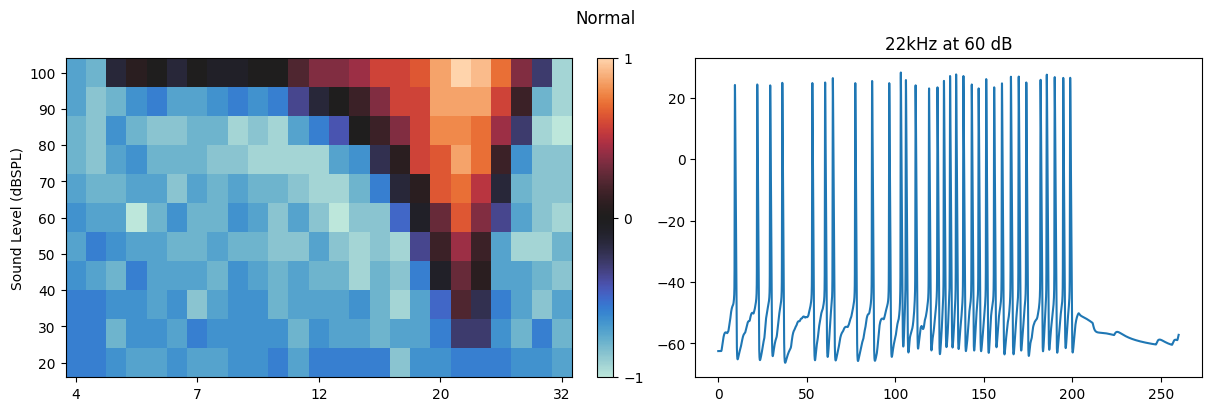

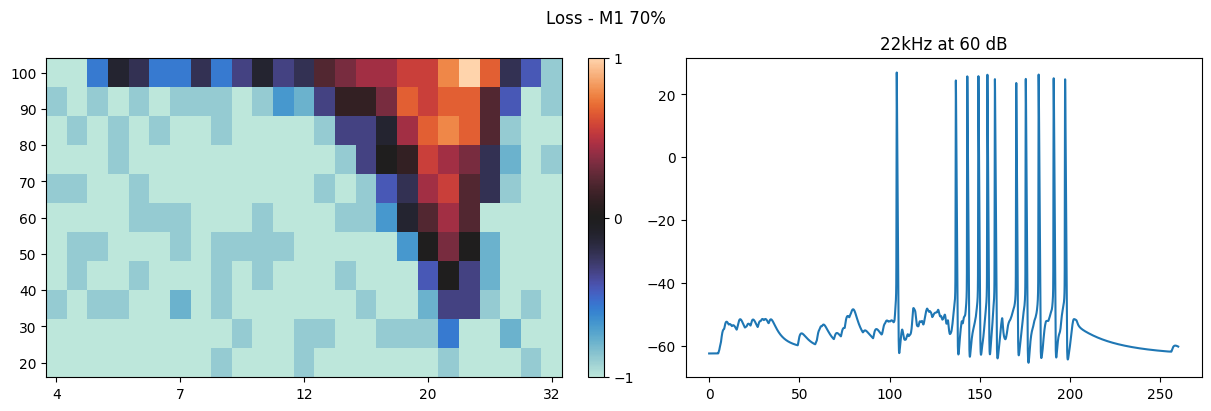

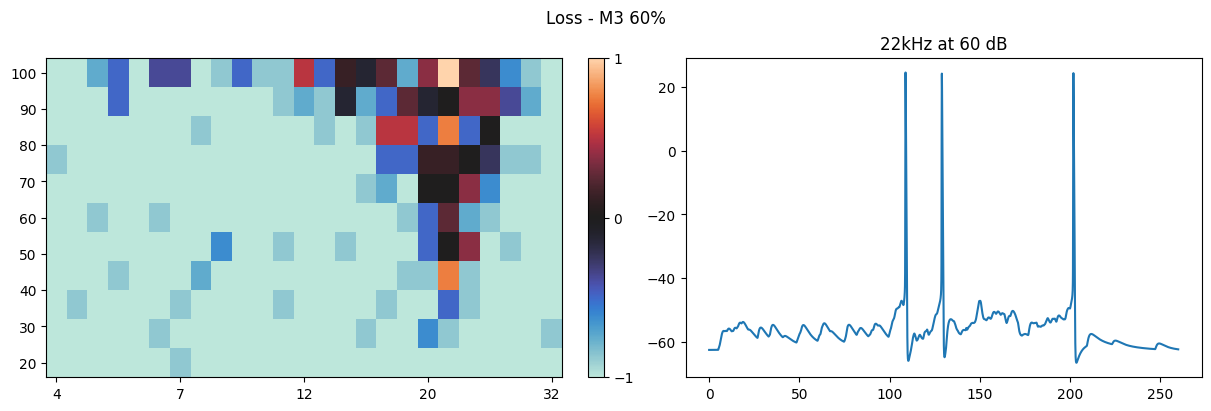

In [7]:
cmap = sns.color_palette("icefire", as_cmap=True)
# matrix_diff = rm_data_loss_m1_95['matrix'] - rm_data_norm['matrix']

fig, axs = plt.subplots(1,2,figsize=(12,4), layout='constrained')  # , sharex=True, sharey=True,

matrix = data_norm['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[0].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap)  #, vmin=-1, vmax=1) 
fig.suptitle('Normal')
axs[0].set_ylabel('Sound Level (dBSPL)')
axs[0].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[0].set_xticklabels([4, 7, 12, 20, 32])
v = results_norm['f0: 22627  dBspl: 60'][1][0][('pyramidal',np.int64(2340))][0]
t = results_norm['f0: 22627  dBspl: 60'][1][0]['t']
axs[1].plot(t,v)
axs[1].set_title('22kHz at 60 dB')
fig.colorbar(im, ticks=[-1,0,1])

fig, axs = plt.subplots(1,2,figsize=(12,4),layout='constrained')
matrix = data_loss_m1_70['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[0].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap)  #, vmin=-1, vmax=1) 
axs[0].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[0].set_xticklabels([4, 7, 12, 20, 32])
fig.suptitle('Loss - M1 70%')
v = results_loss_m1_70['f0: 22627  dBspl: 60'][1][0][('pyramidal',np.int64(2340))][0]
axs[1].plot(t,v)
axs[1].set_title('22kHz at 60 dB')
fig.colorbar(im, ticks=[-1,0,1])

fig, axs = plt.subplots(1,2,figsize=(12,4),layout='constrained')
matrix = data_loss_m3_60['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[0].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap)  #, vmin=-1, vmax=1)  # TODO: change colormap
axs[0].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[0].set_xticklabels([4, 7, 12, 20, 32])
fig.suptitle('Loss - M3 60%')
v = results_loss_m3_60['f0: 22627  dBspl: 60'][1][0][('pyramidal',np.int64(2340))][0]
axs[1].plot(t,v)
axs[1].set_title('22kHz at 60 dB')
fig.colorbar(im, ticks=[-1,0,1])

# for ax in axs:
#     ax.set_xlabel('Frequency (kHz)')


# fig.suptitle('22 kHz Tuned Pyramidal Cell Response');
# fig.set_dpi(300)
# fig.tight_layout()
# fig.savefig(os.path.join(output_dir, 'response_map_difference.png'), dpi=300)

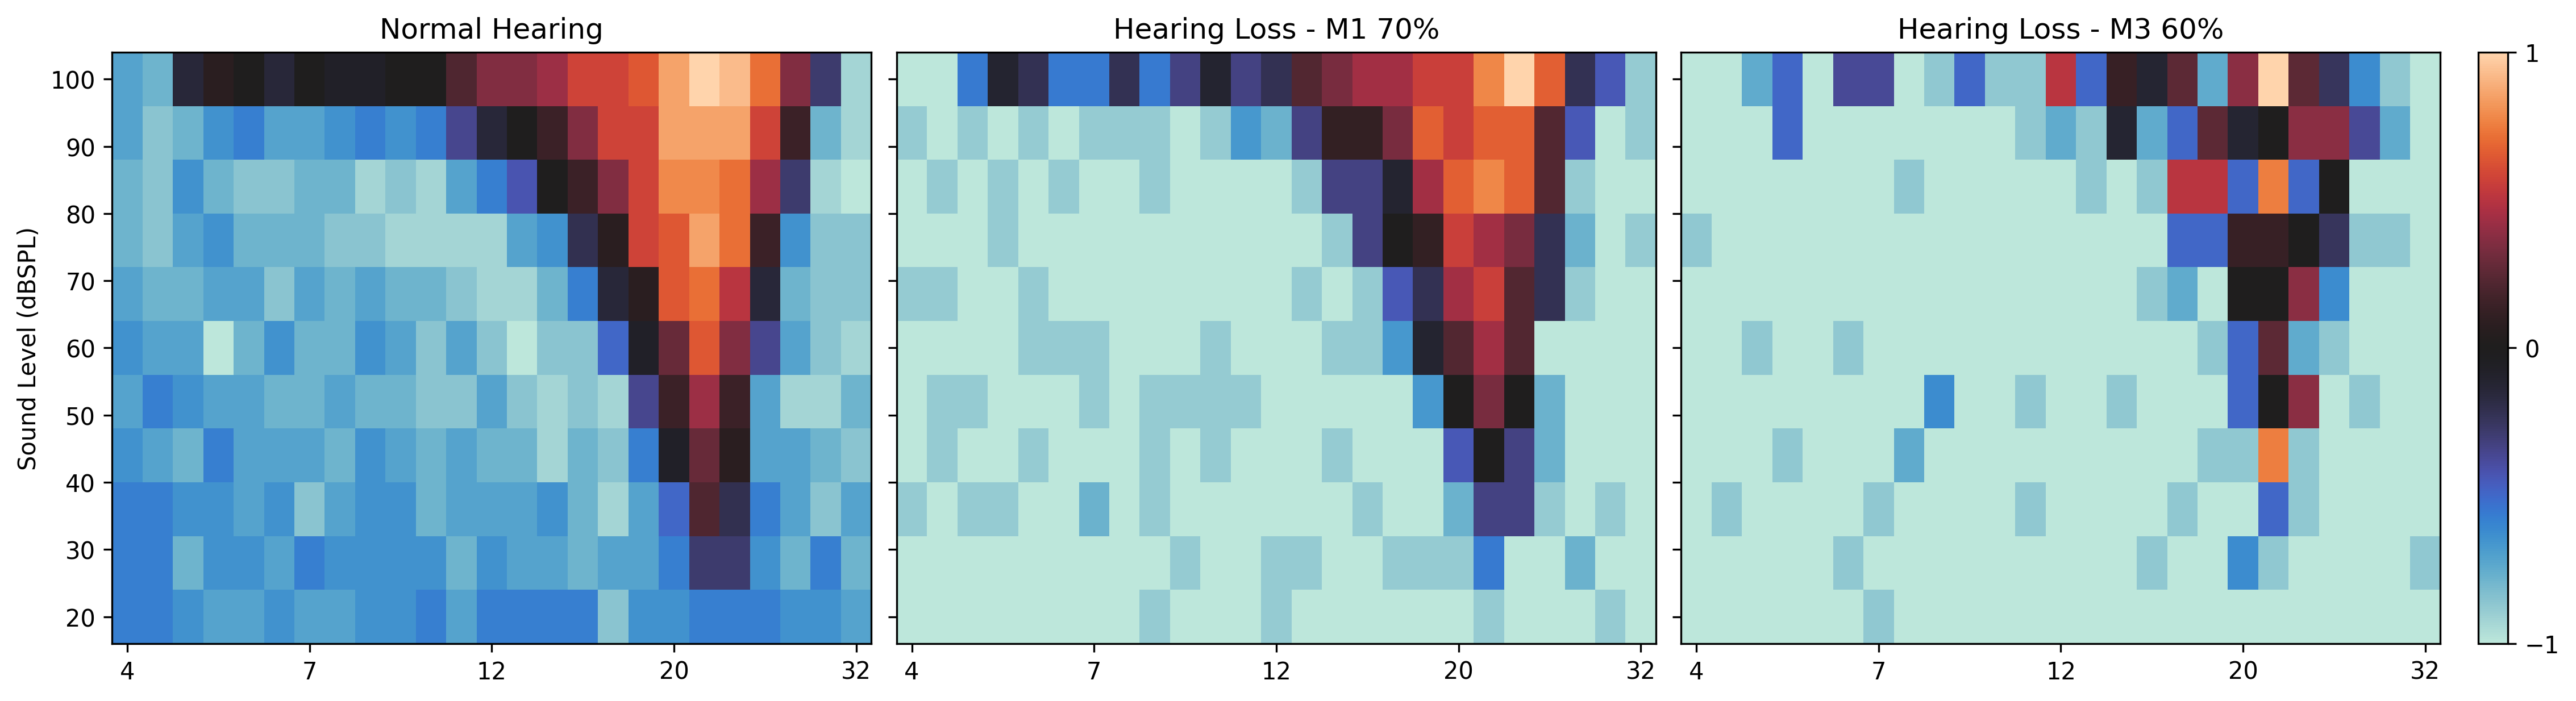

In [13]:
cmap = sns.color_palette("icefire", as_cmap=True)
# matrix_diff = rm_data_loss_m1_95['matrix'] - rm_data_norm['matrix']

fig, axs = plt.subplots(1,3,figsize=(15,4), layout='constrained', sharex=True, sharey=True)

matrix = data_norm['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[0].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap)  #, vmin=-1, vmax=1) 
axs[0].set_title('Normal Hearing')
axs[0].set_ylabel('Sound Level (dBSPL)')
axs[0].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[0].set_xticklabels([4, 7, 12, 20, 32])

matrix = data_loss_m1_70['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[1].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap)  #, vmin=-1, vmax=1) 
axs[1].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[1].set_xticklabels([4, 7, 12, 20, 32])
axs[1].set_title('Hearing Loss - M1 70%')
# fig.colorbar(im, ticks=[-1,0,1])

matrix = data_loss_m3_60['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[2].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap)  #, vmin=-1, vmax=1)  # TODO: change colormap
axs[2].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[2].set_xticklabels([4, 7, 12, 20, 32])
axs[2].set_title('Hearing Loss - M3 60%')
fig.colorbar(im, ticks=[-1,0,1])
fig.set_dpi(300);

# for ax in axs:
#     ax.set_xlabel('Frequency (kHz)')


# fig.suptitle('22 kHz Tuned Pyramidal Cell Response');
# fig.set_dpi(300)
# fig.tight_layout()
# fig.savefig(os.path.join(output_dir, 'response_map_difference.png'), dpi=300)

In [32]:
results_norm = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell-longerstim_loss-m3_60/25fs_11dbs_22000cf-results_od.pkl', 'rb'))

--No graphics will be displayed.


[array([-62.49677822, -62.49677634, -62.49677447, ..., -62.3133812 ,
        -62.31526972, -62.31715072], shape=(10402,)),
 array([108.675, 128.8  , 201.725])]

In [12]:
output_dir = '/home/kedoxey/DCN_model/output/response_maps-wider_loss'
filename = '25fs_11dbs-response_map'
rm_data_norm = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell/DATA-25fs_11dbs_16000cf-response_map.pkl', 'rb'))
rm_data_loss_m1_95 = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m1_95/DATA-25fs_11dbs_16000cf-response_map-loss.pkl', 'rb'))
rm_data_loss_m2 = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m2/DATA-25fs_11dbs_16000cf-response_map-loss.pkl', 'rb'))


In [13]:
freqs_log = rm_data_norm['freqs_log']
levels = rm_data_norm['levels']

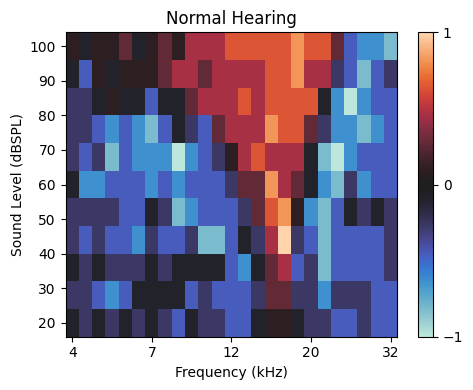

In [22]:
data_norm = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell/DATA-25fs_11dbs_16000cf-response_map.pkl', 'rb'))
# data_norm = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell/DATA-25fs_11dbs_24000cf-response_map.pkl', 'rb'))


freqs_log = data_norm['freqs_log']
levels = data_norm['levels']

cmap = sns.color_palette("icefire", as_cmap=True)
# cmap = cm.twilight

fig, axs = plt.subplots(1,1,figsize=(5,4))  #, layout='constrained')

matrix = data_norm['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs.pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap, vmin=-1, vmax=1) 
axs.set_title('Normal')
axs.set_ylabel('Sound Level (dBSPL)')
axs.set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs.set_xticklabels([4, 7, 12, 20, 32])

# title = 'Hearing Loss' if 'loss' in self.hearing else 'Normal Hearing'
axs.set_title('Normal Hearing')
axs.set_xlabel('Frequency (kHz)')

fig.colorbar(im, ticks=[-1,0,1])
# fig.set_dpi(200)
fig.tight_layout()
fig.savefig('16kHz-normal_hearing_normalized.pdf', dpi=300)

## Loss-m1 - Normal

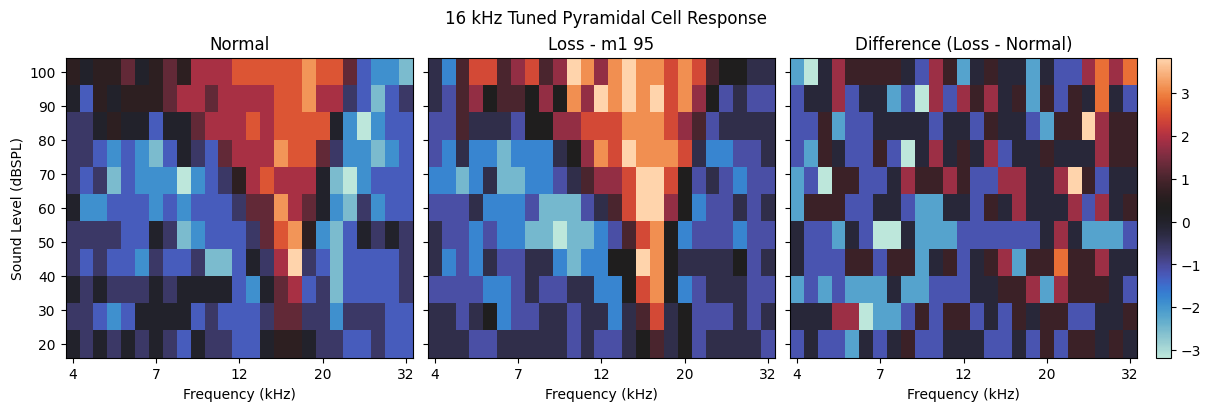

In [8]:
cmap = sns.color_palette("icefire", as_cmap=True)
matrix_diff = rm_data_loss_m1_95['matrix'] - rm_data_norm['matrix']

fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True, layout='constrained')

matrix = rm_data_norm['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
axs[0].pcolormesh(freqs_log, levels, rm_data_norm['matrix'], cmap=cmap)  #, vmin=-1, vmax=1) 
axs[0].set_title('Normal')
axs[0].set_ylabel('Sound Level (dBSPL)')

matrix = rm_data_loss_m1_95['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
axs[1].pcolormesh(freqs_log, levels, rm_data_loss_m1_95['matrix'], cmap=cmap)  #, vmin=-1, vmax=1) 
axs[1].set_title('Loss - m1 95')

matrix = matrix_diff
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[2].pcolormesh(freqs_log, levels, matrix_diff, cmap=cmap)  #, vmin=-1, vmax=1)  # TODO: change colormap
axs[2].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[2].set_xticklabels([4, 7, 12, 20, 32])

# title = 'Hearing Loss' if 'loss' in self.hearing else 'Normal Hearing'
axs[2].set_title('Difference (Loss - Normal)')

for ax in axs:
    ax.set_xlabel('Frequency (kHz)')

fig.colorbar(im)  #, ticks=[-1,0,1])
fig.suptitle('16 kHz Tuned Pyramidal Cell Response');
# fig.set_dpi(200)
# fig.tight_layout()
# fig.savefig(os.path.join(output_dir, 'response_map_difference.png'), dpi=300)

In [9]:
rm_data_norm_24000 = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell/DATA-25fs_11dbs_24000cf-response_map.pkl', 'rb'))
rm_data_loss_m1_24000 =pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m1_95/DATA-25fs_11dbs_24000cf-response_map-loss.pkl', 'rb'))


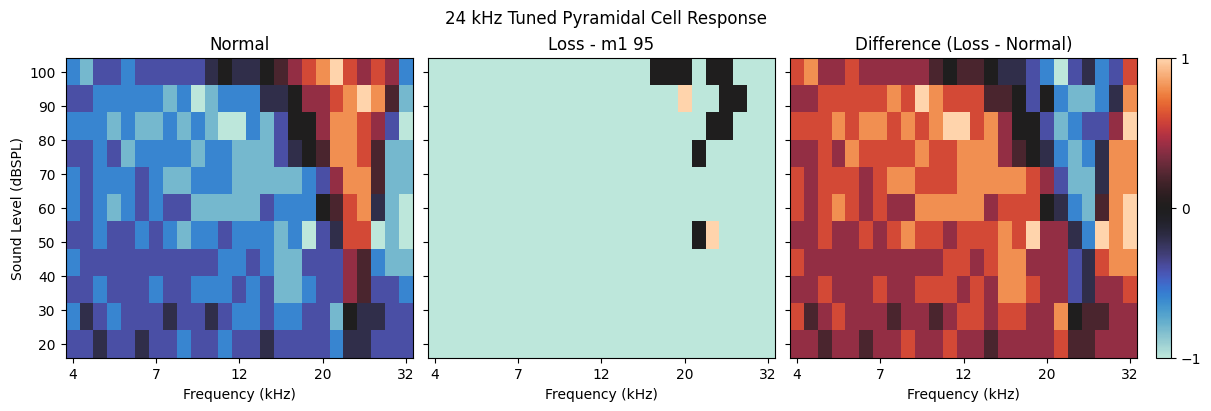

In [13]:
cmap = sns.color_palette("icefire", as_cmap=True)
matrix_diff = rm_data_loss_m1_24000['matrix'] - rm_data_norm_24000['matrix']

fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True, layout='constrained')

matrix = rm_data_norm_24000['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
axs[0].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap, vmin=-1, vmax=1) 
axs[0].set_title('Normal')
axs[0].set_ylabel('Sound Level (dBSPL)')

matrix = rm_data_loss_m1_24000['matrix']
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
axs[1].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap, vmin=-1, vmax=1) 
axs[1].set_title('Loss - m1 95')

matrix = matrix_diff
matrix_norm = 2*((matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))) - 1
im = axs[2].pcolormesh(freqs_log, levels, matrix_norm, cmap=cmap, vmin=-1, vmax=1)  # TODO: change colormap
axs[2].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[2].set_xticklabels([4, 7, 12, 20, 32])

# title = 'Hearing Loss' if 'loss' in self.hearing else 'Normal Hearing'
axs[2].set_title('Difference (Loss - Normal)')

for ax in axs:
    ax.set_xlabel('Frequency (kHz)')

fig.colorbar(im, ticks=[-1,0,1])
fig.suptitle('24 kHz Tuned Pyramidal Cell Response');
# fig.set_dpi(200)
# fig.tight_layout()
# fig.savefig(os.path.join(output_dir, 'response_map_difference.png'), dpi=300)

## Loss-m2 - Normal

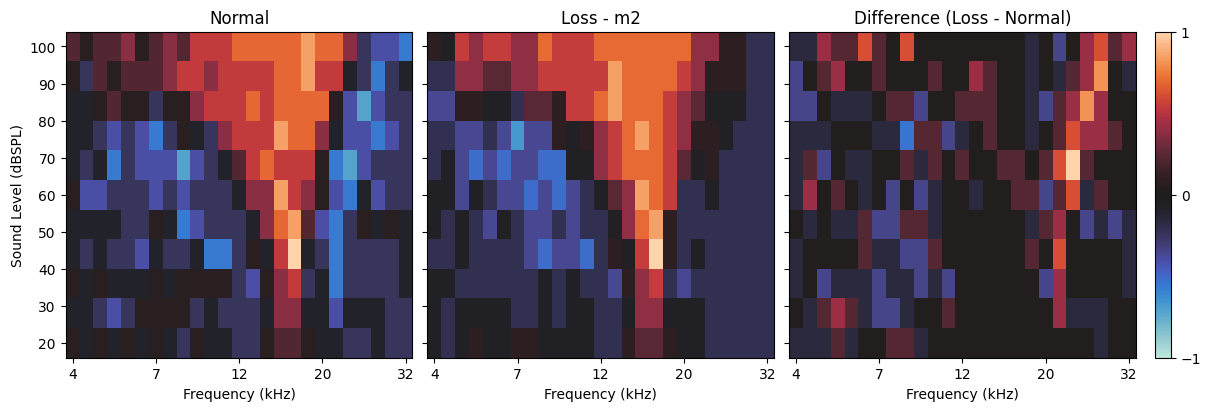

In [8]:
cmap = sns.color_palette("icefire", as_cmap=True)
matrix = rm_data_loss_m2['matrix'] - rm_data_norm['matrix']

fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True, layout='constrained')

axs[0].pcolormesh(freqs_log, levels, rm_data_norm['matrix']/np.max(rm_data_norm['matrix']), cmap=cmap, vmin=-1, vmax=1) 
axs[0].set_title('Normal')
axs[0].set_ylabel('Sound Level (dBSPL)')

axs[1].pcolormesh(freqs_log, levels, rm_data_loss_m2['matrix']/np.max(rm_data_loss_m2['matrix']), cmap=cmap, vmin=-1, vmax=1) 
axs[1].set_title('Loss - m2')

im = axs[2].pcolormesh(freqs_log, levels, matrix/np.max(matrix), cmap=cmap, vmin=-1, vmax=1)  # TODO: change colormap
axs[2].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[2].set_xticklabels([4, 7, 12, 20, 32])

# title = 'Hearing Loss' if 'loss' in self.hearing else 'Normal Hearing'
axs[2].set_title('Difference (Loss - Normal)')

for ax in axs:
    ax.set_xlabel('Frequency (kHz)')

fig.colorbar(im, ticks=[-1,0,1])
# fig.set_dpi(200)
# fig.tight_layout()
fig.savefig(os.path.join(output_dir, 'response_map_difference.png'), dpi=300)

## IC - Normal

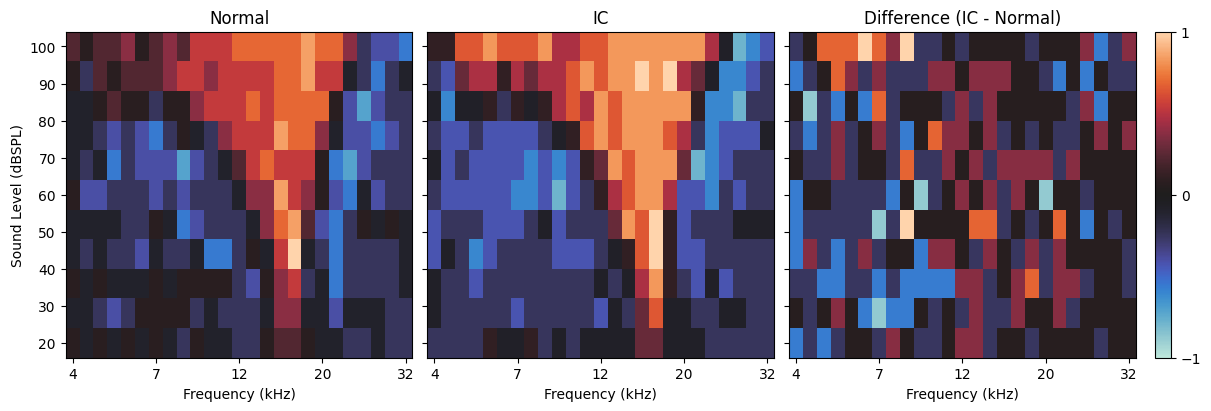

In [8]:

matrix = rm_data_ic['matrix'] - rm_data_norm['matrix']

fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True, layout='constrained')

axs[0].pcolormesh(freqs_log, levels, rm_data_norm['matrix']/np.max(rm_data_norm['matrix']), cmap=cmap, vmin=-1, vmax=1) 
axs[0].set_title('Normal')
axs[0].set_ylabel('Sound Level (dBSPL)')

axs[1].pcolormesh(freqs_log, levels, rm_data_ic['matrix']/np.max(rm_data_ic['matrix']), cmap=cmap, vmin=-1, vmax=1) 
axs[1].set_title('IC')

im = axs[2].pcolormesh(freqs_log, levels, matrix/np.max(matrix), cmap=cmap, vmin=-1, vmax=1)  # TODO: change colormap
axs[2].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[2].set_xticklabels([4, 7, 12, 20, 32])

# title = 'Hearing Loss' if 'loss' in self.hearing else 'Normal Hearing'
axs[2].set_title('Difference (IC - Normal)')

for ax in axs:
    ax.set_xlabel('Frequency (kHz)')

fig.colorbar(im, ticks=[-1,0,1])
# fig.set_dpi(200)
# fig.tight_layout()
fig.savefig(os.path.join(output_dir, 'response_map_difference.png'), dpi=300)

## IC - Loss

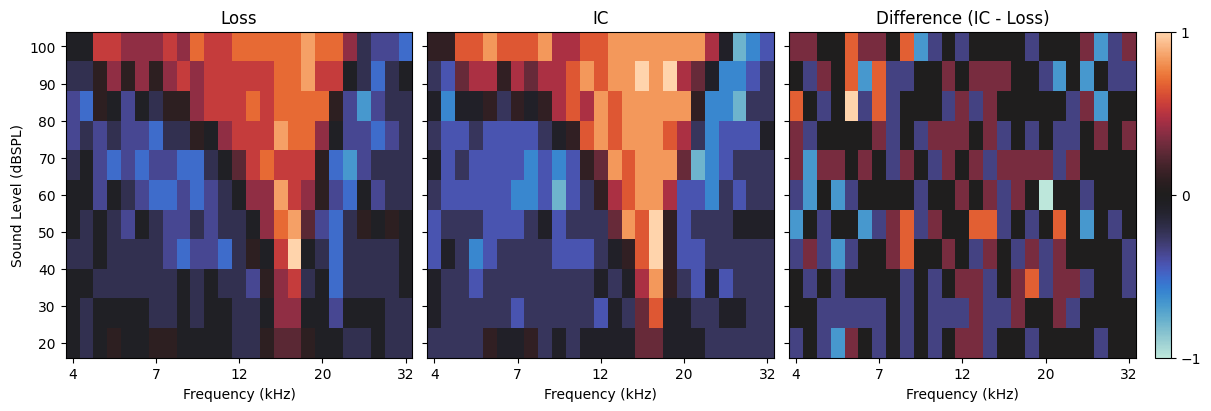

In [9]:

matrix = rm_data_ic['matrix'] - rm_data_loss['matrix']

fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True, layout='constrained')

axs[0].pcolormesh(freqs_log, levels, rm_data_loss['matrix']/np.max(rm_data_loss['matrix']), cmap=cmap, vmin=-1, vmax=1) 
axs[0].set_title('Loss')
axs[0].set_ylabel('Sound Level (dBSPL)')

axs[1].pcolormesh(freqs_log, levels, rm_data_ic['matrix']/np.max(rm_data_ic['matrix']), cmap=cmap, vmin=-1, vmax=1) 
axs[1].set_title('IC')

im = axs[2].pcolormesh(freqs_log, levels, matrix/np.max(matrix), cmap=cmap, vmin=-1, vmax=1)  # TODO: change colormap
axs[2].set_xticks([freqs_log[i] for i in [0, 6, 12, 18, 24]])
axs[2].set_xticklabels([4, 7, 12, 20, 32])

# title = 'Hearing Loss' if 'loss' in self.hearing else 'Normal Hearing'
axs[2].set_title('Difference (IC - Loss)')

for ax in axs:
    ax.set_xlabel('Frequency (kHz)')

fig.colorbar(im, ticks=[-1,0,1])
# fig.set_dpi(200)
# fig.tight_layout()
fig.savefig(os.path.join(output_dir, 'response_map_difference.png'), dpi=300)

## NetPyNE

In [ ]:
file_name = 'Ix0.5_2-10cells-0.025_220ms-NSA_60Hz-num_spikes.npy'
# file_name = 'Ix0.5_2-10cells-num_spikes.npy'
file_path = f'/home/kedoxey/DCN_model/output/no_W-log/data/{file_name}'

num_spikes = np.load(file_path, allow_pickle=True).item()
# num_spikes = np.load(file_name, allow_pickle=True).item()


In [4]:
num_spikes[1.5]

{0.0: {0: nan,
  1: nan,
  2: nan,
  3: nan,
  4: nan,
  5: nan,
  6: nan,
  7: nan,
  8: nan,
  9: nan,
  10: nan,
  11: nan,
  12: nan,
  13: nan,
  14: nan,
  15: nan,
  16: nan,
  17: nan,
  18: nan,
  19: nan,
  20: nan,
  21: nan,
  22: nan,
  23: nan,
  24: nan,
  25: nan,
  26: nan,
  27: nan,
  28: nan,
  29: nan,
  30: nan,
  31: nan,
  32: nan,
  33: nan,
  34: nan,
  35: nan,
  36: nan,
  37: nan,
  38: nan,
  39: nan,
  40: nan,
  41: nan,
  42: nan,
  43: nan,
  44: nan,
  45: nan,
  46: nan,
  47: nan,
  48: nan,
  49: nan,
  50: nan,
  51: nan,
  52: nan,
  53: nan,
  54: nan,
  55: nan,
  56: nan,
  57: nan,
  58: nan,
  59: nan,
  60: nan,
  61: nan,
  62: nan,
  63: nan,
  64: nan,
  65: nan,
  66: nan,
  67: nan,
  68: nan,
  69: nan,
  70: nan,
  71: nan,
  72: nan,
  73: nan,
  74: nan,
  75: nan,
  76: nan,
  77: nan,
  78: nan,
  79: nan,
  80: nan,
  81: nan,
  82: nan,
  83: nan,
  84: nan,
  85: nan,
  86: nan,
  87: nan,
  88: nan,
  89: nan,
  90: nan,
  91

In [82]:
p_spon_freq = num_spikes[0.5][0][0]
p_spon_freq

45.045045045056106

78.951078528144
78.951078528144
78.951078528144
78.951078528144


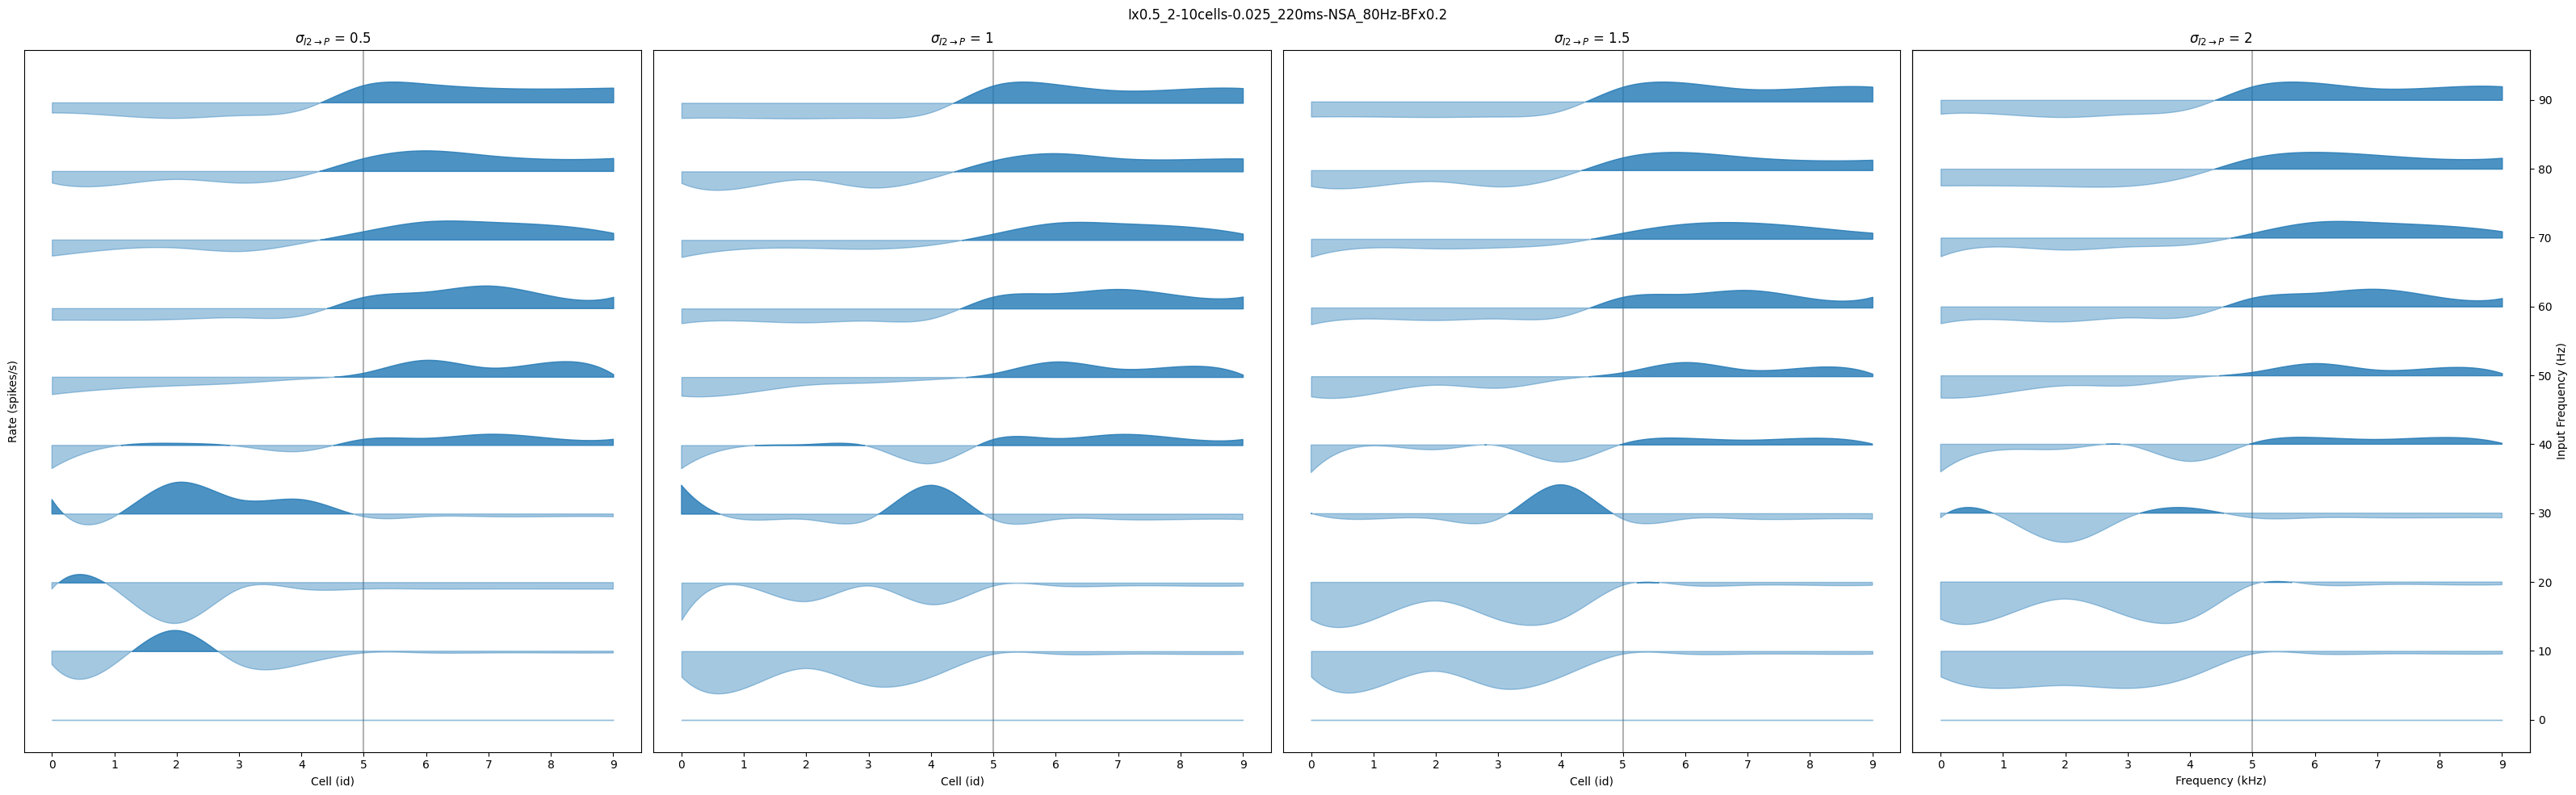

In [2]:
n_cells = 10
sim_flag = 'no_W-np_params'
sim_label = f'Ix0.5_2-{n_cells}cells-0.025_220ms-NSA_80Hz-BFx0.2'
sim_dir = f'/home/kedoxey/DCN_model/output/{sim_flag}/{sim_label}'
file_name = f'{sim_label}-num_spikes.npy'
# file_name = 'Ix0.5_2-10cells-num_spikes.npy'
file_path = f'/home/kedoxey/DCN_model/output/{sim_flag}/data/{file_name}'

num_spikes = np.load(file_path, allow_pickle=True).item()


i_weights = list(num_spikes.keys())
bfs = list(num_spikes[i_weights[0]].keys())
bfs_lin = [10*i for i in range(len(bfs))]

col_list = pd.MultiIndex.from_tuples([(i_w, bf) for i_w in i_weights for bf in bfs])  # [(bf, i_w) for i_w in num_spikes.keys() for bf in num_spikes[i_w].keys()])

n_cells = len(num_spikes[i_weights[0]][bfs[0]])

num_spikes_arr = np.ones((len(i_weights), n_cells, len(bfs)), dtype=int)

for i, weight_vals in enumerate(num_spikes.values()):

    for j, bf_vals in enumerate(weight_vals.values()):

        for cell_id, n_spikes in bf_vals.items():
            
            if np.isnan(n_spikes):
                n_spikes = 0

            num_spikes_arr[i, cell_id, j] = n_spikes

num_spikes_arr = np.concatenate([num_spikes_arr[i,:,:] for i in range(len(i_weights))], axis=1)

num_spikes_df = pd.DataFrame(num_spikes_arr, columns=col_list)

if 0 in i_weights:
    i_weights.remove(0)

fig, axs = plt.subplots(1, len(i_weights), figsize=(8*len(i_weights),10))

# p_spon_freq = 36
scale = 0.2

ax2 = axs[-1].twinx()

for i, i_w in enumerate(i_weights):

    p_spon_freq = num_spikes[i_w][0][0]
    print(p_spon_freq)

    yticks = []
    ax = axs[i] if len(i_weights) > 1 else axs

    if i == len(i_weights)-1: ax = ax2

    for bf_i, (bf, col) in enumerate(num_spikes_df[i_w].items()):
        # print(bf)
        # print(col.values)

        # if bf == 0:
        #     continue

        bf = bfs_lin[bf_i]

        yticks.append(bf*scale)

        cs = CubicSpline(range(n_cells), col, axis=0)
        new_cells = np.linspace(0, n_cells-1, 1000)
        new_spikes = cs(new_cells)

        amp = col.max() - col.min()
        if amp == 0: amp = 100
        diff = (new_spikes - p_spon_freq) / amp
        # pos = diff.copy()
        # pos[pos < 0] = 0
        # neg = diff.copy()
        # neg[neg > 0] = 0
        # temp = 5

        octaves = [i for i in range(n_cells)]

        # axs[i].plot(col.values + bf*scale)
        # axs[i].plot([p_spon_freq + bf*scale for i in col.values])
        ax.fill_between(new_cells, diff + bf*scale, [bf*scale for i in new_spikes], where=diff>=0, interpolate=True, color='tab:blue', alpha=0.8, zorder=12)
        ax.fill_between(new_cells, diff + bf*scale, [bf*scale for i in new_spikes], where=diff<=0, interpolate=True, color='tab:blue', alpha=0.4, zorder=12)
        # axs[i].fill_between(octaves, pos + bf*scale, [bf*scale for i in col.values], color='tab:blue', alpha=0.8)
        # axs[i].fill_between(octaves, neg + bf*scale, [bf*scale for i in col.values], color='tab:blue', alpha=0.4)

    ax.set_title(r'$\sigma_{I2\rightarrow P}$ = '+ f'{i_w}')
    # ax.set_xticks([(n_cells-1)*i for i in [0, 0.25, 0.5, 0.75, 1]]) 
    # ax.set_xticklabels(['1.25', '', '5', '', '20'])
    # ax.set_xlabel('Input (kHz)')
    ax.set_xticks([i for i in range(n_cells)]) 
    ax.set_xlabel('Cell (id)')
    ax.set_yticks([])
    ax.set_yticklabels('')

    ax.axvline(n_cells//2, color='k', alpha=0.3, zorder=0)

axs[-1].set_yticks([])
axs[-1].set_yticklabels('')
axs[-1].set_xlabel('Frequency (kHz)')
    
ax2.set_ylabel('Input Frequency (Hz)')  #Sound level (db)')
ax2.set_yticks(yticks)
ax2.set_yticklabels(bfs_lin)
# ax2.set_yticklabels(bfs)


axs[0].set_ylabel('Rate (spikes/s)')

fig.suptitle(sim_label)
fig.tight_layout()
fig.savefig(os.path.join(sim_dir, 'response_map.png'), dpi=300)


In [14]:
zero_spikes = num_spikes_df[0.5][0].values
cells = list(num_spikes_df[0.5][0].index)

cs = CubicSpline(cells, zero_spikes, axis=0)
new_cells = np.linspace(0, 9, 100)
new_spikes = cs(new_cells)
len(new_spikes)


100

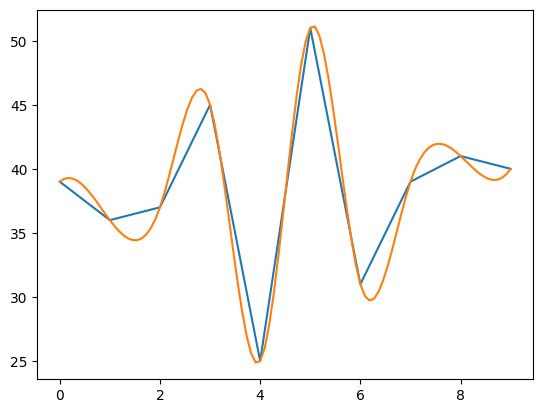

In [37]:
plt.plot(cells, zero_spikes)
plt.plot(new_cells, new_spikes)

In [9]:
file_name_05 = 'Ix0.5-100cells-0.025_220ms-num_spikes.npy'

num_spikes_05 = np.load(f'output/data/{file_name_05}', allow_pickle=True).item()



In [10]:
i_weights = list(num_spikes_05.keys())
bfs = list(num_spikes_05[i_weights[0]].keys())

col_list = pd.MultiIndex.from_tuples([(i_w, bf) for i_w in i_weights for bf in bfs])  # [(bf, i_w) for i_w in num_spikes.keys() for bf in num_spikes[i_w].keys()])
col_list

MultiIndex([(0.5,  0),
            (0.5, 10),
            (0.5, 20),
            (0.5, 30),
            (0.5, 40),
            (0.5, 50),
            (0.5, 60)],
           )

In [11]:
n_cells = len(num_spikes_05[i_weights[0]][bfs[0]])

num_spikes_05_arr = np.ones((len(i_weights), n_cells, len(bfs)), dtype=int)

for i, weight_vals in enumerate(num_spikes_05.values()):

    for j, bf_vals in enumerate(weight_vals.values()):

        for cell_id, n_spikes in bf_vals.items():
            
            if np.isnan(n_spikes):
                n_spikes = 0

            num_spikes_05_arr[i, cell_id, j] = n_spikes

num_spikes_05_arr = np.concatenate([num_spikes_05_arr[i,:,:] for i in range(len(i_weights))], axis=1)

In [12]:
num_spikes_05_df = pd.DataFrame(num_spikes_05_arr, columns=col_list)
num_spikes_05_df

0.5                        
    0   10  20  30  40  50  60
0   31  27  24  32  28  39  21
1   36  39  39  40  36  22  24
2   33  38  21  18  16  19  20
3   30  24  40  48  36  45  42
4   39  28  28  20  23  12  66
..  ..  ..  ..  ..  ..  ..  ..
95  32  44  44  35  36  38  19
96  39  43  36  29  32  41  42
97  36  35  23  24  23  11  24
98  37  21  30  28  48  36  40
99  41  30  39  63  18  29  26

[100 rows x 7 columns]

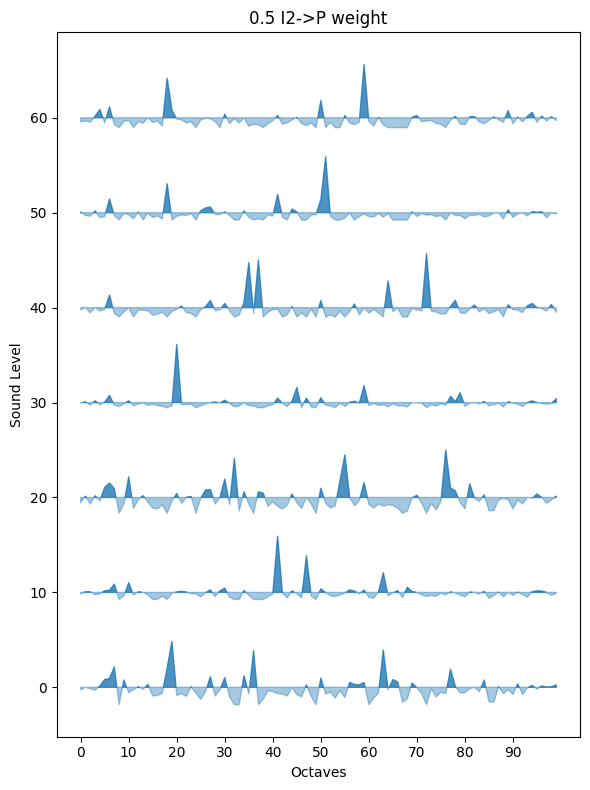

In [13]:
fig, axs = plt.subplots(1, len(i_weights), figsize=(6*len(i_weights),8))

p_spon_freq = 36
scale = 0.15

for i, i_w in enumerate(i_weights):

    yticks = []
    ax = axs[i] if len(i_weights) > 1 else axs

    for bf, col in num_spikes_05_df[i_w].items():
        # print(bf)
        # print(col.values)

        yticks.append(bf*scale)

        diff = (col.values - p_spon_freq) / (col.max() - col.min())
        pos = diff.copy()
        pos[pos < 0] = 0
        neg = diff.copy()
        neg[neg > 0] = 0
        temp = 5

        octaves = [i for i in range(n_cells)]

        # axs[i].plot(col.values + bf*scale)
        # axs[i].plot([p_spon_freq + bf*scale for i in col.values])
        ax.fill_between(octaves, diff + bf*scale, [bf*scale for i in col.values], where=diff>=0, interpolate=True, color='tab:blue', alpha=0.8)
        ax.fill_between(octaves, diff + bf*scale, [bf*scale for i in col.values], where=diff<=0, interpolate=True, color='tab:blue', alpha=0.4)
        # axs[i].fill_between(octaves, pos + bf*scale, [bf*scale for i in col.values], color='tab:blue', alpha=0.8)
        # axs[i].fill_between(octaves, neg + bf*scale, [bf*scale for i in col.values], color='tab:blue', alpha=0.4)

    ax.set_title(f'{i_w} I2->P weight')
    ax.set_xticks([10*i for i in range(n_cells//10)])
    # ax.set_xticklabels([i for i in range(1,n_cells+1)])
    ax.set_xlabel('Octaves')
    ax.set_yticks(yticks)
    ax.set_yticklabels(bfs)

ax.set_ylabel('Sound Level')

fig.tight_layout()

In [16]:
i_weights

[0.5]

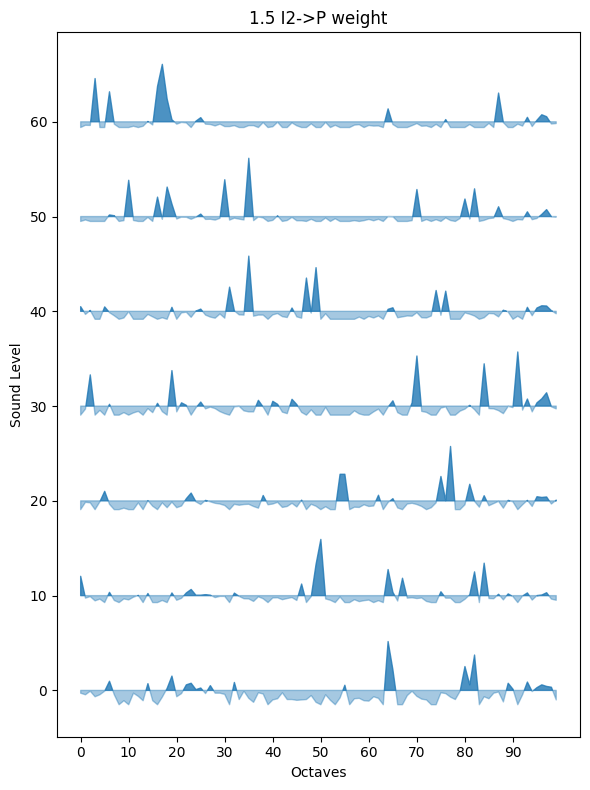

In [17]:
file_name_15 = 'Ix1.5-100cells-0.025_220ms-num_spikes.npy'

num_spikes_15 = np.load(f'output/data/{file_name_15}', allow_pickle=True).item()

i_weights = list(num_spikes_15.keys())
bfs = list(num_spikes_15[i_weights[0]].keys())

col_list = pd.MultiIndex.from_tuples([(i_w, bf) for i_w in i_weights for bf in bfs])  # [(bf, i_w) for i_w in num_spikes.keys() for bf in num_spikes[i_w].keys()])

n_cells = len(num_spikes_15[i_weights[0]][bfs[0]])

num_spikes_15_arr = np.ones((len(i_weights), n_cells, len(bfs)), dtype=int)

for i, weight_vals in enumerate(num_spikes_15.values()):

    for j, bf_vals in enumerate(weight_vals.values()):

        for cell_id, n_spikes in bf_vals.items():
            
            if np.isnan(n_spikes):
                n_spikes = 0

            num_spikes_15_arr[i, cell_id, j] = n_spikes

num_spikes_15_arr = np.concatenate([num_spikes_15_arr[i,:,:] for i in range(len(i_weights))], axis=1)

num_spikes_15_df = pd.DataFrame(num_spikes_15_arr, columns=col_list)

fig, axs = plt.subplots(1, len(i_weights), figsize=(6*len(i_weights),8))

p_spon_freq = 36
scale = 0.15

for i, i_w in enumerate(i_weights):

    yticks = []
    ax = axs[i] if len(i_weights) > 1 else axs

    for bf, col in num_spikes_15_df[i_w].items():
        # print(bf)
        # print(col.values)

        yticks.append(bf*scale)

        diff = (col.values - p_spon_freq) / (col.max() - col.min())
        pos = diff.copy()
        pos[pos < 0] = 0
        neg = diff.copy()
        neg[neg > 0] = 0
        temp = 5

        octaves = [i for i in range(n_cells)]

        # axs[i].plot(col.values + bf*scale)
        # axs[i].plot([p_spon_freq + bf*scale for i in col.values])
        ax.fill_between(octaves, diff + bf*scale, [bf*scale for i in col.values], where=diff>=0, interpolate=True, color='tab:blue', alpha=0.8)
        ax.fill_between(octaves, diff + bf*scale, [bf*scale for i in col.values], where=diff<=0, interpolate=True, color='tab:blue', alpha=0.4)
        # axs[i].fill_between(octaves, pos + bf*scale, [bf*scale for i in col.values], color='tab:blue', alpha=0.8)
        # axs[i].fill_between(octaves, neg + bf*scale, [bf*scale for i in col.values], color='tab:blue', alpha=0.4)

    ax.set_title(f'{i_w} I2->P weight')
    ax.set_xticks([10*i for i in range(n_cells//10)])
    # ax.set_xticklabels([i for i in range(1,n_cells+1)])
    ax.set_xlabel('Octaves')
    ax.set_yticks(yticks)
    ax.set_yticklabels(bfs)

ax.set_ylabel('Sound Level')

fig.tight_layout()


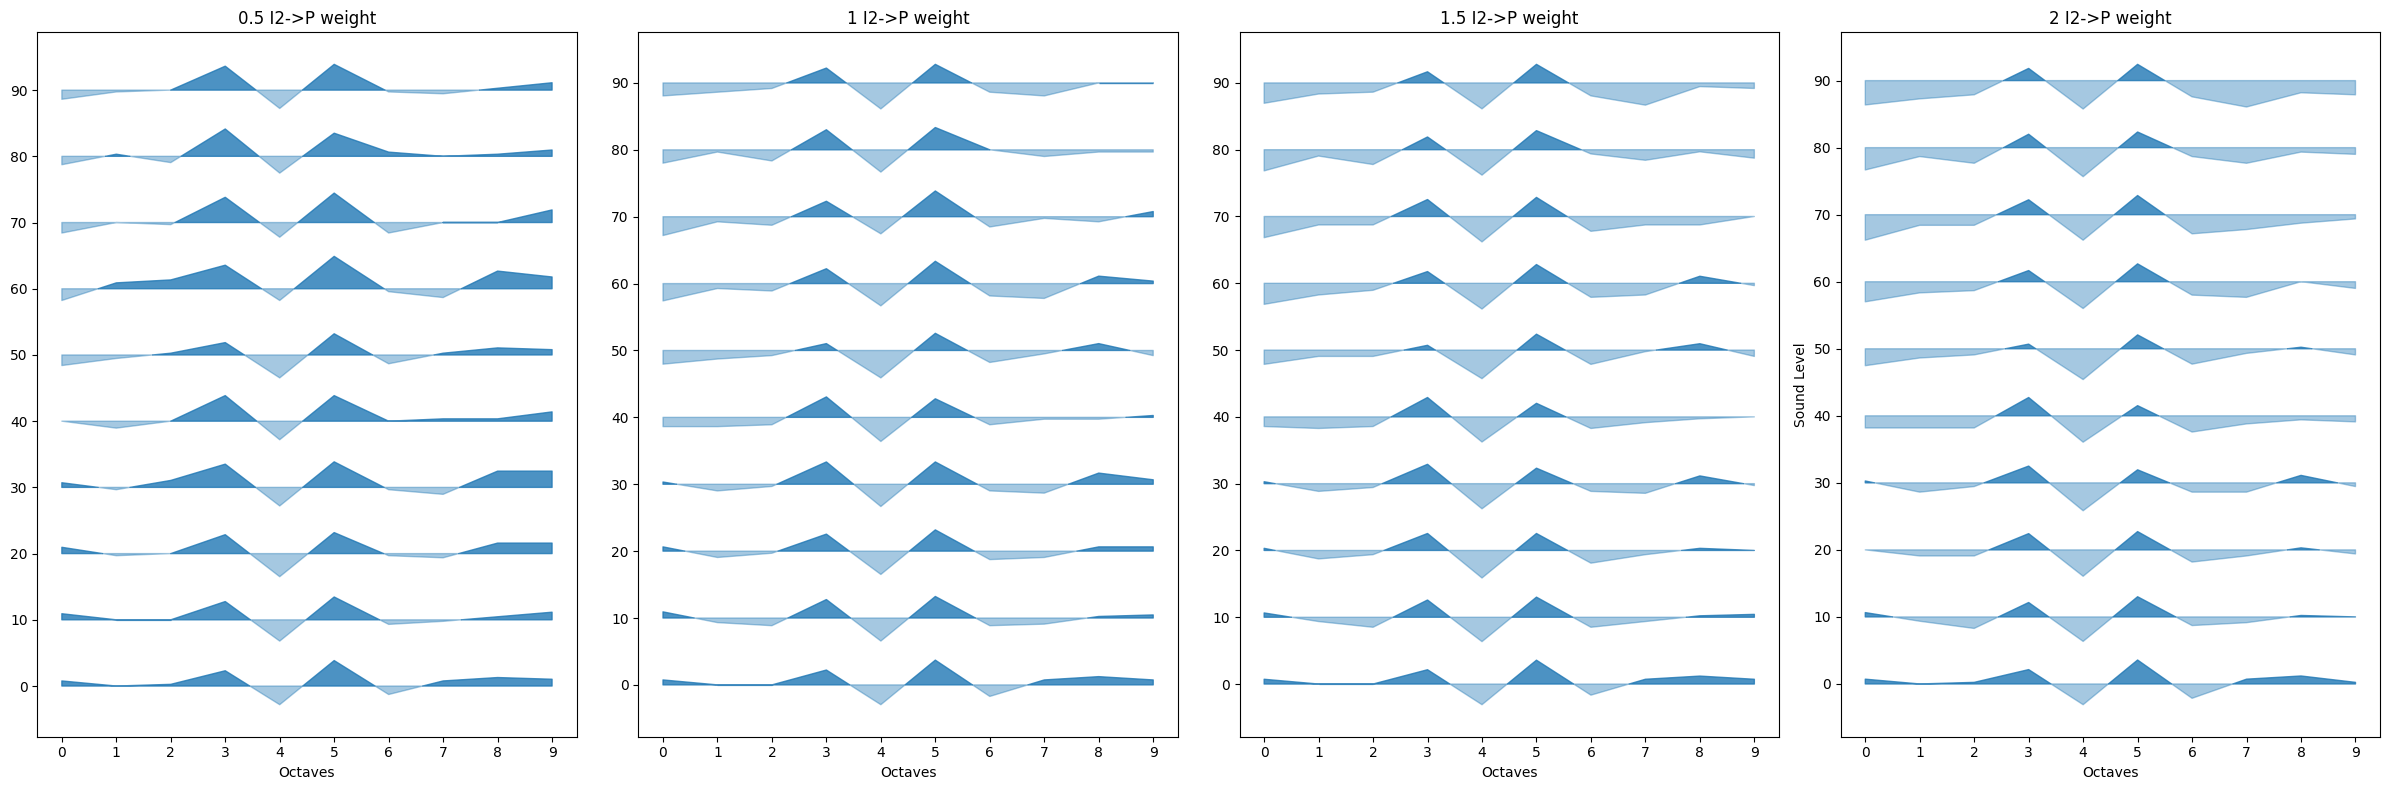

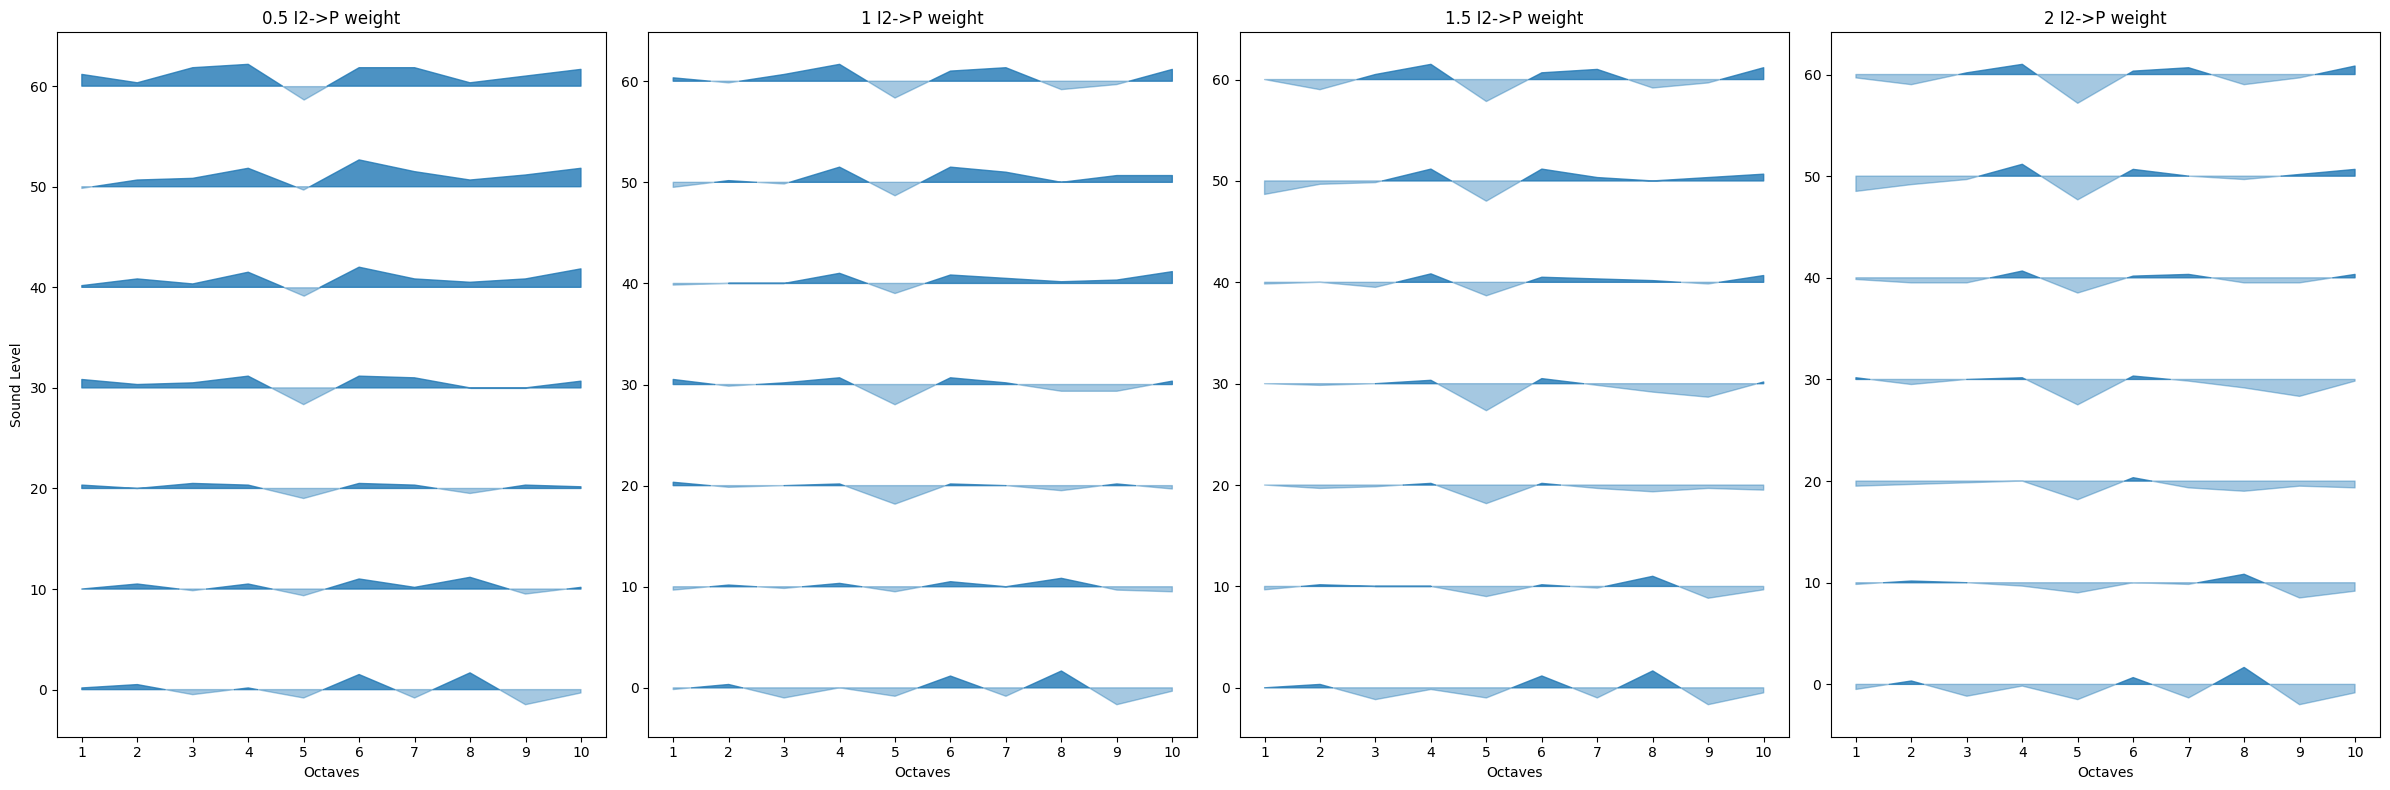

In [41]:
fig, axs = plt.subplots(1, len(i_weights), figsize=(6*len(i_weights),8))

p_spon_freq = 36
scale = 6

for i, i_w in enumerate(i_weights):

    yticks = []

    for bf, col in num_spikes_df[i_w].items():
        # print(bf)
        # print(col.values)

        yticks.append(bf*scale)

        diff = col.values - p_spon_freq
        pos = diff.copy()
        pos[pos < 0] = 0
        neg = diff.copy()
        neg[neg > 0] = 0
        temp = 5

        octaves = [i for i in range(n_cells)]

        # axs[i].plot(col.values + bf*scale)
        # axs[i].plot([p_spon_freq + bf*scale for i in col.values])
        axs[i].fill_between(octaves, diff + bf*scale, [bf*scale for i in col.values], where=diff>=0, interpolate=True, color='tab:blue', alpha=0.8)
        axs[i].fill_between(octaves, diff + bf*scale, [bf*scale for i in col.values], where=diff<=0, interpolate=True, color='tab:blue', alpha=0.4)
        # axs[i].fill_between(octaves, pos + bf*scale, [bf*scale for i in col.values], color='tab:blue', alpha=0.8)
        # axs[i].fill_between(octaves, neg + bf*scale, [bf*scale for i in col.values], color='tab:blue', alpha=0.4)

        # axs[i].fill_between(octaves, diff + bf*scale, [bf*scale for i in col.values], where=diff>=0, interpolate=True, color='blue')
        # axs[i].fill_between(octaves, [bf*scale for i in col.values], where=diff+bf*scale<=bf*scale, interpolate=True, color='red')

    axs[i].set_title(f'{i_w} I2->P weight')
    axs[i].set_xticks([i for i in range(n_cells)])
    # axs[i].set_xticklabels([i for i in range(1,n_cells+1)])
    axs[i].set_xlabel('Cells (id)')
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(bfs)

axs[0].set_ylabel('Sound Level')

fig.tight_layout()